<a href="https://colab.research.google.com/github/VladimirBoshnjakovski/explainable-ai-thesis-code/blob/main/02_Iinterpretable_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ──────────────── DATA HANDLING ────────────────
from google.colab import files
import pandas as pd

# ──────────────── VISUALIZATION ────────────────
import matplotlib.pyplot as plt  # For plotting and visualizations
import seaborn as sns            # For advanced statistical plots

# ──────────────── MACHINE LEARNING ────────────────
from sklearn.linear_model import LogisticRegression                     # Logistic regression model
from sklearn.model_selection import train_test_split                   # Train/test split utility
from sklearn.preprocessing import StandardScaler                       # Feature scaling
from sklearn.metrics import (                                          # Model evaluation metrics
    classification_report, confusion_matrix,
    accuracy_score, roc_auc_score, roc_curve


)

In [2]:
# ──────────────── LOAD DATASET FROM LOCAL FILE (Colab Upload) ────────────────
uploaded = files.upload()  # Opens file picker to upload from your computer
df = pd.read_csv(next(iter(uploaded)))  # Loads the first uploaded file into a DataFrame

Saving encoded_heart_disease_data.csv to encoded_heart_disease_data.csv


✅ Model Evaluation:
Accuracy: 0.8333333333333334
ROC AUC Score: 0.8895417156286722

Confusion Matrix:
 [[16  7]
 [ 3 34]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.76        23
           1       0.83      0.92      0.87        37

    accuracy                           0.83        60
   macro avg       0.84      0.81      0.82        60
weighted avg       0.83      0.83      0.83        60



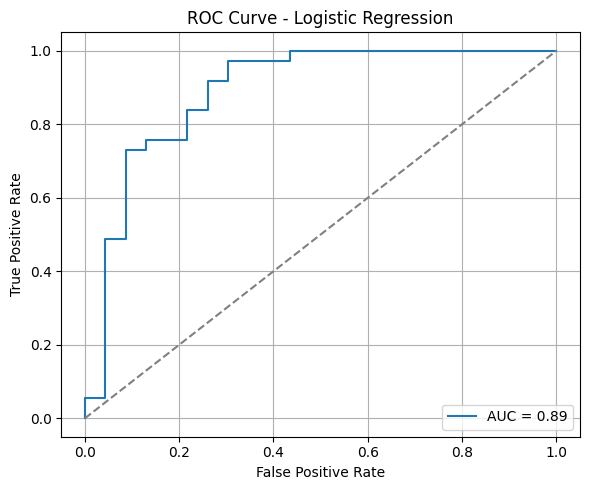

In [3]:
# ──────────────── 1. DEFINE TARGET AND FEATURES ────────────────
target = 'Presence of Heart Disease (1=Yes)'
X = df.drop(columns=[target])               # All columns except the target
y = df[target].astype(int)                  # Convert target to integer (binary 0/1)

# ──────────────── 2. IDENTIFY CONTINUOUS NUMERICAL FEATURES ────────────────
# Only keep int/float columns with more than 2 unique values (exclude binaries/dummies)
numerical_cols = [
    col for col in X.columns
    if df[col].dtype in ['int64', 'float64'] and df[col].nunique() > 2
]

# ──────────────── 3. TRAIN/TEST SPLIT ────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ──────────────── 4. SCALE CONTINUOUS FEATURES ONLY ────────────────
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# ──────────────── 5. TRAIN LOGISTIC REGRESSION MODEL ────────────────
logreg = LogisticRegression(max_iter=1000, solver='liblinear')  # Good for small datasets
logreg.fit(X_train_scaled, y_train)

# ──────────────── 6. PREDICT ON TEST SET ────────────────
y_pred = logreg.predict(X_test_scaled)                         # Predicted class labels
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]            # Predicted probabilities for class 1

# ──────────────── 7. EVALUATION METRICS ────────────────
print("✅ Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ──────────────── 8. PLOT ROC CURVE ────────────────
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()




🔍 Top Features (by absolute weight):
                                           Feature  Coefficient
11  Number of Major Vessels Colored by Fluoroscopy    -1.045653
31                  Thalassemia: Reversible Defect     0.730055
2                   Chest Pain Type (4 Categories)     0.659884
27                                  ST Slope: Flat    -0.532423
13                                     Sex: Female     0.494974
3                   Resting Blood Pressure (mm Hg)    -0.463294
1                           Sex (0=Female, 1=Male)    -0.432159
14                                       Sex: Male    -0.432159
28                           ST Slope: Downsloping     0.383422
9                ST Depression Induced by Exercise    -0.365884


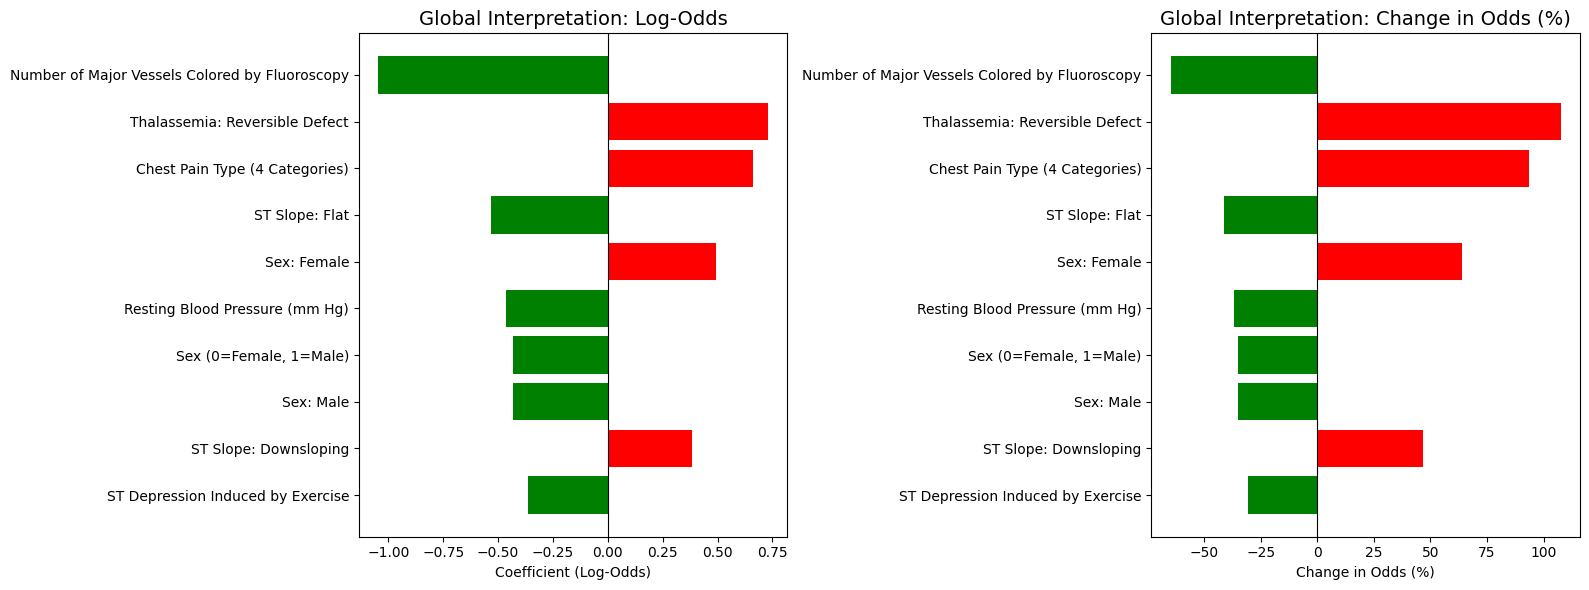

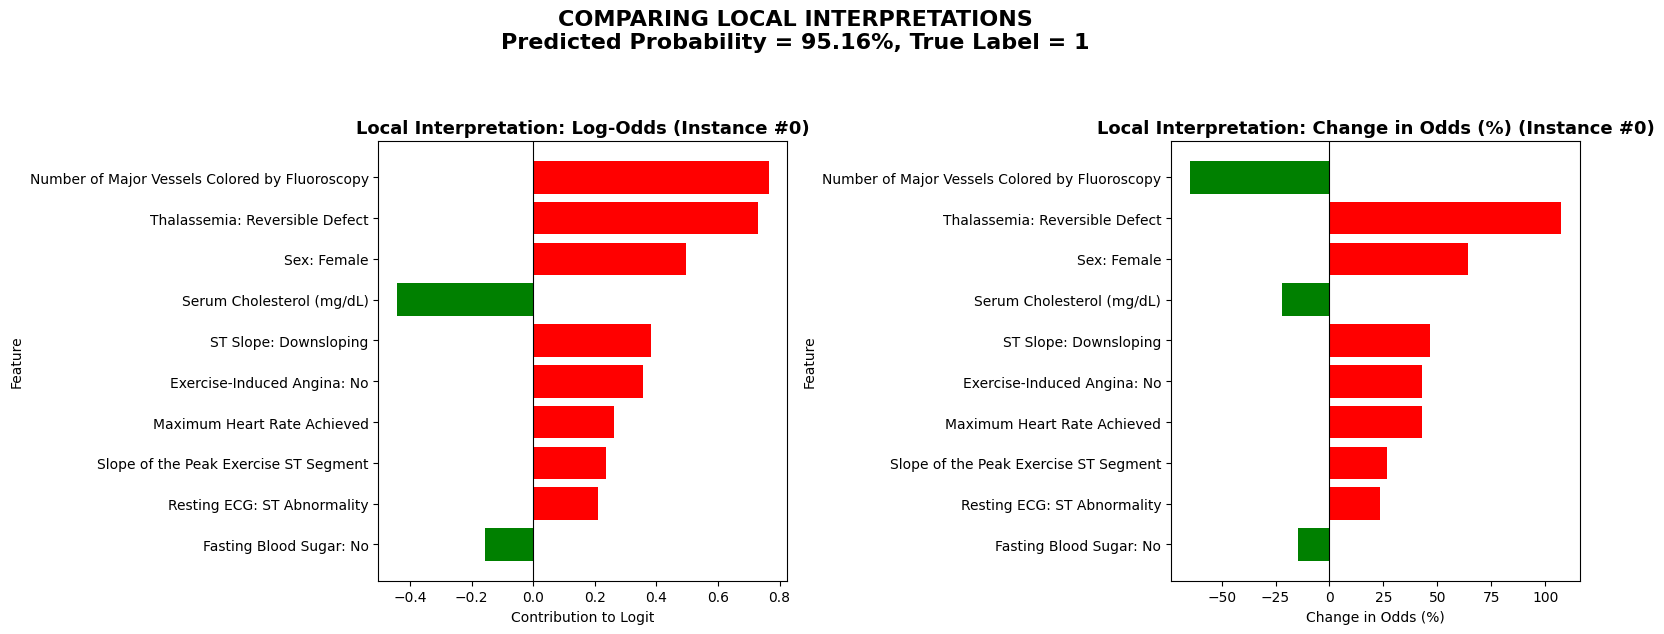


🧠 Local Prediction Summary for Instance #0
True Label = 1
Predicted Probability = 95.16%
Logit (raw sum + intercept) = 2.9785


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ──────────────── GLOBAL FEATURE IMPORTANCE (TOP 10 BY ABSOLUTE COEFFICIENT) ────────────────
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]
})
coeff_df['Abs Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs Coefficient', ascending=False)

print("\n🔍 Top Features (by absolute weight):")
print(coeff_df[['Feature', 'Coefficient']].head(10))

# Extract coefficients, intercept, and feature names for local interpretation
coefficients = logreg.coef_[0]
intercept = logreg.intercept_[0]
features = X.columns

# ──────────────── LOCAL INTERPRETATION ────────────────
k = 1  # Unit change used for interpreting % change in odds
instance_index = 0  # Index of test instance for local interpretation

# Select specific instance from test set
x_instance = X_test_scaled.iloc[instance_index]  # Standardized values
x_original = X_test.iloc[instance_index]         # Original feature values
y_true = y_test.iloc[instance_index]             # True label

# Compute contribution to logit from each feature
contributions = x_instance.values * coefficients
logit = np.sum(contributions) + intercept
pred_prob = 1 / (1 + np.exp(-logit))  # Sigmoid function

# Local Log-Odds (feature contributions for one instance)
local_df_logodds = pd.DataFrame({
    'Feature': features,
    'Original Value': x_original.values,
    'Standardized Value': x_instance.values,
    'Coefficient (Log-Odds)': coefficients,
    'Contribution to Logit': contributions
})
local_df_logodds['Abs Contribution'] = local_df_logodds['Contribution to Logit'].abs()
top_local_logodds = local_df_logodds.sort_values(by='Abs Contribution', ascending=False).head(10)

# Local % Change in Odds (global coefficients used)
local_df_pct = pd.DataFrame({
    'Feature': features,
    'Original Value': x_original.values,
    'Standardized Value': x_instance.values,
    'Contribution to Logit': contributions,
    f'Change in Odds for +{k} Unit(s) (%)': (np.exp(k * coefficients) - 1) * 100
})
local_df_pct['Abs Contribution'] = local_df_pct['Contribution to Logit'].abs()
top_local_pct = local_df_pct.sort_values(by='Abs Contribution', ascending=False).head(10)

# ──────────────── PLOT 1: GLOBAL INTERPRETATION ────────────────
top_coef_logodds = coeff_df[['Feature', 'Coefficient']].head(10)
top_coef_pct = coeff_df.copy()
top_coef_pct[f'Change in Odds for +{k} Unit(s) (%)'] = (np.exp(k * top_coef_pct['Coefficient']) - 1) * 100
top_coef_pct = top_coef_pct.sort_values(by='Abs Coefficient', ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot: Global Log-Odds
axes[0].barh(
    top_coef_logodds['Feature'],
    top_coef_logodds['Coefficient'],
    color=['red' if c > 0 else 'green' for c in top_coef_logodds['Coefficient']]
)
axes[0].axvline(0, color='black', linewidth=0.8)
axes[0].set_title("Global Interpretation: Log-Odds", fontsize=14)
axes[0].set_xlabel("Coefficient (Log-Odds)")
axes[0].invert_yaxis()

# Barplot: Global Change in Odds
axes[1].barh(
    top_coef_pct['Feature'],
    top_coef_pct[f'Change in Odds for +{k} Unit(s) (%)'],
    color=['red' if x > 0 else 'green' for x in top_coef_pct[f'Change in Odds for +{k} Unit(s) (%)']]
)
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].set_title("Global Interpretation: Change in Odds (%)", fontsize=14)
axes[1].set_xlabel("Change in Odds (%)")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# ──────────────── PLOT 2: LOCAL INTERPRETATION (SIDE-BY-SIDE + TITLE) ────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Custom title above both subplots
fig.suptitle(
    f"COMPARING LOCAL INTERPRETATIONS\nPredicted Probability = {pred_prob:.2%}, True Label = {y_true}",
    fontsize=16,
    fontweight='bold',
    y=1.05  # raise the title a bit above the plots
)

# Left: Local Log-Odds
axes[0].barh(
    top_local_logodds['Feature'],
    top_local_logodds['Contribution to Logit'],
    color=['red' if c > 0 else 'green' for c in top_local_logodds['Contribution to Logit']]
)
axes[0].axvline(0, color='black', linewidth=0.8)
axes[0].set_title(f"Local Interpretation: Log-Odds (Instance #{instance_index})", fontsize=13, fontweight='bold')
axes[0].set_xlabel("Contribution to Logit")
axes[0].set_ylabel("Feature")
axes[0].invert_yaxis()

# Right: Local % Change in Odds
axes[1].barh(
    top_local_pct['Feature'],
    top_local_pct[f'Change in Odds for +{k} Unit(s) (%)'],
    color=['red' if x > 0 else 'green' for x in top_local_pct[f'Change in Odds for +{k} Unit(s) (%)']]
)
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].set_title(f"Local Interpretation: Change in Odds (%) (Instance #{instance_index})", fontsize=13, fontweight='bold')
axes[1].set_xlabel("Change in Odds (%)")
axes[1].set_ylabel("Feature")
axes[1].invert_yaxis()

plt.tight_layout()
plt.subplots_adjust(top=0.83)  # adjust for main title spacing
plt.show()

# ──────────────── LOCAL SUMMARY ────────────────
print(f"\n🧠 Local Prediction Summary for Instance #{instance_index}")
print(f"True Label = {y_true}")
print(f"Predicted Probability = {pred_prob:.2%}")
print(f"Logit (raw sum + intercept) = {logit:.4f}")
